# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. 

<b>Цель исследования: </b> Определить, какие факторы и как сильно влияют на стоимость квартиры. 
<br>Также в ходе анализа попробуем предположить, какие ошибки чаще всего допускаются в данных и из-за чего. 

<b>Гипотеза:</b> стоимость объкта напрямую зависит от:
    <br>- общей площади;
    <br>- жилой площади;
    <br>- площади кухни;
    <br>- количества комнат;
    <br>- этажа, на котором расположена квартира (первый, последний, другой);
    <br>- даты размещения (день недели, месяц, год)


    
<b>Ход исследования</b>
    <br>1. Обзор данных
   <br>2. Предобработка данных, выявление аномальных значений и их причин
   <br>3. Исследовательский анализ и проверка гипотез


### Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

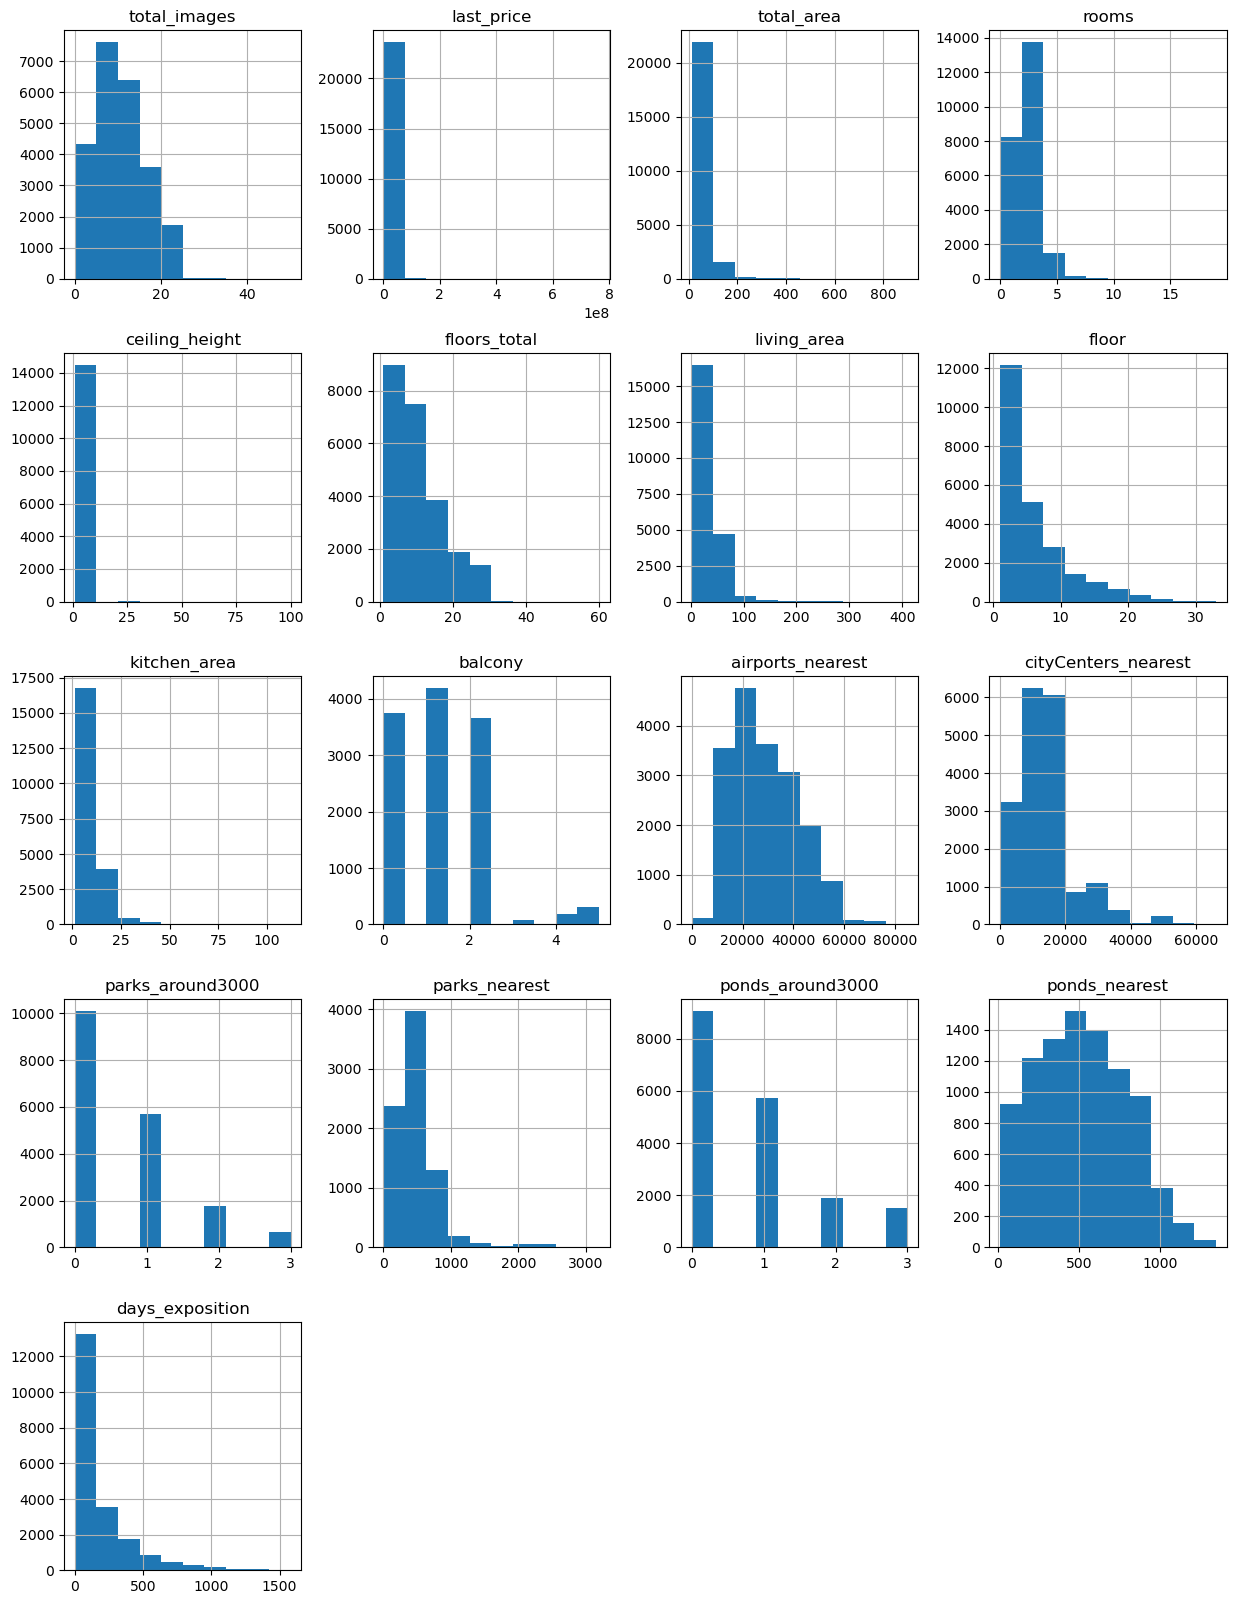

In [2]:
#при первом просмотре названия колонок были смешаны, а значения собраны только в последних столбцах. 
#применяем разделитель для колонок sep
data = pd.read_csv('real_estate_data.csv', sep = '\t') 
data.head(15) #теперь таблица выглядит верно :) 
data.info() #некоторые столбцы имеют нулевые значения, а также неверный формат 
data.hist(figsize=(15, 20));

### Предобработка данных

#### **Избавимся от пропусков в данных:**

In [3]:
data.columns.sort_values() #проверяем названия столбцов
data.isna().sum() #считаем количество пропусков в столбцах
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


**Возможные причины пропусков:**
- ceiling_height, living_area, kitchen_area - могли быть не добавлены, если хозяин не знал точные цифры, либо планировал обсуждать их при личном разговоре с покупателем
- floors_total, locality_name - пропущены случайно (их очень мало + эти данные точно известны хозяину квартиры)
- is_apartment, balcony - скорее всего не указаны хозяином, так как отсутствуют
- airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000,ponds_nearest - картографические, следовательно, таких объектов поблизости нет
- days_exposition - скорее всего, считается автоматически на сайте при публикации и снятии объявления, значит, это может быть техническая ошибка, либо неполнота данных от коллег (если они этот параметр считают самостоятельно)

In [4]:
#сначала заменим те значения, где нужный объект в квартире отсутствует

columns0 = ['balcony', 'parks_around3000', 'ponds_around3000']  #эти значения заменим на '0'
for column in columns0:
    data[column] = data[column].fillna(0)    
data['is_apartment'] = data['is_apartment'].fillna(False) #а тут на False, т.к.булев тип

In [5]:
#с другими значениями можно попробовать восстановить данные

data['ceiling_height'].value_counts()  #посмотрим на значения высоты потолков
#Может быть, хозяин квартиры не указал данные по высоте потолка, потому что они были стандартными? 
#В таком случае мы можем заменить пропущенные значения самым частым - 2,5 метра.
data['ceiling_height'] = data['ceiling_height'].fillna(2.50)


#посмотрим, какие площади квартир встречаются чаще всего и средние значения
data['living_area'].value_counts().sort_values(ascending = False) 
data['living_area'].median()
data['living_area'].mean()
#среднее и медианное значения будут искажать данные, 
#т.к почти в два раза больше, чем самые частотные значения (18,17)

data['kitchen_area'].value_counts().sort_values(ascending = False) 
data['kitchen_area'].median()
data['kitchen_area'].mean()

#площадь кухни не так сильно варьируется,поэтому тут мы можем сделать замену на медианное значение
data['kitchen_area'] = data['kitchen_area'].fillna(9)

#попробуем посчитать примерную площадь жилого пространства, вычтя площадь кухни 
data['living_area'] = data['living_area'].fillna(0)

for index in range(len(data)):
    if (data['living_area'][index]==0)&(data['balcony'][index]==0):
            data['living_area'][index] = data['total_area'][index] - data['kitchen_area'][index]

C:\Users\Людмила\AppData\Local\Temp\ipykernel_2208\4181637647.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['living_area'][index] = data['total_area'][index] - data['kitchen_area'][index]


In [6]:
#проверим этажи:
data['floors_total'].value_counts()
data['floors_total'].median()

#для начала заменим все отсутствующие этажи медианным значением
data['floors_total'] = data['floors_total'].fillna(9)

#проверим, не случилось ли такого, что этаж квартиры выше общего количества этажей
for index in range(len(data)):
    while data['floor'][index]>data['floors_total'][index]:
        data['floors_total'][index] +=1
        
#заменяем значения, где данных нет, либо их сложно восстановить
#можно примерно определить название по близости аэропорта и центра города, но пока сделать это вручную кажется проще:)

data['locality_name'] = data['locality_name'].fillna('Без названия')

C:\Users\Людмила\AppData\Local\Temp\ipykernel_2208\4166163266.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['floors_total'][index] +=1


airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest оставим с пустыми значениями, чтобы можно было проводить вычисления. Заменять на 0 или медианное значение столбца некорректно.
В идеале можно сгруппировать данные по населенным пунктам и написать средние значения по имеющимся данным

In [7]:
data[data['airports_nearest'].isna()] #посмотрим, в каких населенных пунктах есть пропуски по этим столбцам
data[data['locality_name']=='посёлок Мурино'] #проверим выборочно по одному н.п.
#большинство пропусков в этих четырех столбцах находятся в одних и тех же населенных пунктах, 
#поэтому восстановить данные не получится

data.isna().sum() #проверяем итогово

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Проверим типы данных в столбцах:**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

В каких столбцах меняем типы данных:
- first_day_exposition - должна быть в формате даты
- floors_total, balcony, parks_around3000, ponds_around3000 - переводим в формат int64, так как количество этих объектов может быть только целым числом

In [9]:
#меняем формат даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

#меняем формат столбцов с целыми числами

data['balcony'] = data['balcony'].astype(int)
data['floors_total'] = data['floors_total'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['last_price'] = data['last_price'].astype(int)
                                                           
data.info() #проверяем


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

#### **Изучим дубликаты:**

In [10]:
data.duplicated() #явных дубликатов в датафрейме нет

sorted(data['locality_name'].unique())
#заменяем неявные дубликаты
data['locality_name'] = data['locality_name'].replace('деревня Калитино','деревня Кальтино')
data['locality_name'] = data['locality_name'].replace('городской посёлок Лесогорский','поселок городского типа Лесогорский')
data['locality_name'] = data['locality_name'].replace('городской посёлок Назия','поселок городского типа Назия')
data['locality_name'] = data['locality_name'].replace('городской посёлок Мга','поселок городского типа Мга')
data['locality_name'] = data['locality_name'].replace('городской посёлок Рощино','посёлок городского типа Рощино')
data['locality_name'] = data['locality_name'].replace('городской посёлок Советский','поселок городского типа Советский')
data['locality_name'] = data['locality_name'].replace('деревня Фёдоровское','городской посёлок Фёдоровское')

#необходимо заменить букву "е" на "ё" в слове посёлок
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')

sorted(data['locality_name'].unique())

['Без названия',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской посёлок Большая Ижора',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Свирьстрой',
 'городской посёлок Фёдоровское',
 'городской посёлок Янино-1',
 'деревня Агалатово',
 'деревня Аро',
 'деревня Батово',
 'деревня Бегуницы',
 'деревня Белогорка',
 'деревня Большая Вруда',
 'деревня Больш

#### **Проверим наличие аномальных значений в столбцах**

C:\Users\Людмила\AppData\Local\Temp\ipykernel_2208\4111394411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ceiling_height'][index] = data['ceiling_height'][index]/10


array([2.7, 2.5, 3. , 2.6, 2.8, 2.9, 3.2, 3.4, 4.2, 3.5, 3.3, 4. , 3.1,
       2.3, 3.7, 5.2, 2. , 2.4, 3.6, 3.8, 5.3, 5. , 4.1, 4.7, 5.6, 3.9,
       4.8, 4.5, 4.4, 5.5, 4.3, 4.6, 2.2, 6. , 5.8, 4.9])

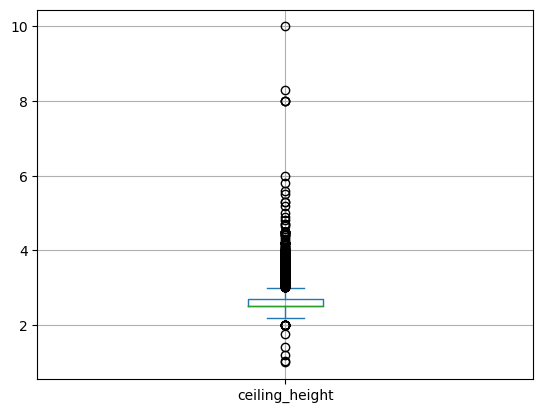

In [11]:
#корректируем значения в столбце высоты потолков
sorted(data['ceiling_height'].unique())
        
for index in range(len(data)):
    if data['ceiling_height'][index] >= 10.3:
        data['ceiling_height'][index] = data['ceiling_height'][index]/10

data['ceiling_height'].plot(kind = 'box', grid = True)

#удалим строки, где высота потолков ниже 2 (выходят за пределы нормальных значений),
#и выше 6 (т.к.значений ниже 6, но больше нормального размаха достаточно много)
data['ceiling_height'] = data['ceiling_height'].round(1) #округляем для наглядности

data = data.query('ceiling_height >= 2.0 and ceiling_height <= 6.0')
data['ceiling_height'].unique()


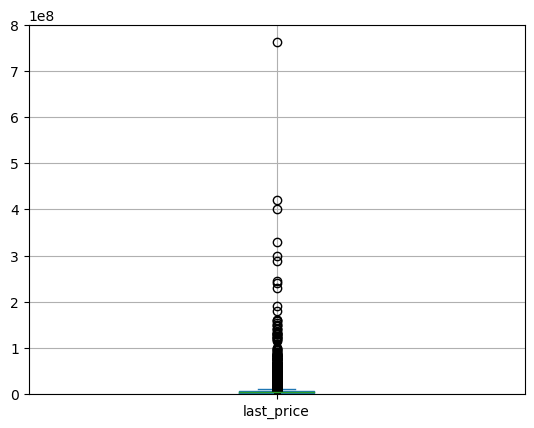

In [12]:
#проверим данные по разным числовым столбцам
data['last_price'].plot(kind = 'box', grid = True)
plt.ylim(0,800000000)
data['last_price'].describe()

#уберем неверно указанное минимальное число
data['last_price'].min()
data = data.query('last_price > 12190.0')

data[data['last_price']>200000000].count() #9 строк 
#уберем значения, которые выше "усов", но только редкие - где на графике видны отдельные точки
data = data.query('last_price < 200000000')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23679 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23679 non-null  int64         
 1   last_price            23679 non-null  int32         
 2   total_area            23679 non-null  float64       
 3   first_day_exposition  23679 non-null  datetime64[ns]
 4   rooms                 23679 non-null  int64         
 5   ceiling_height        23679 non-null  float64       
 6   floors_total          23679 non-null  int32         
 7   living_area           23679 non-null  float64       
 8   floor                 23679 non-null  int64         
 9   is_apartment          23679 non-null  bool          
 10  studio                23679 non-null  bool          
 11  open_plan             23679 non-null  bool          
 12  kitchen_area          23679 non-null  float64       
 13  balcony         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23234 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23234 non-null  int64         
 1   last_price            23234 non-null  int32         
 2   total_area            23234 non-null  float64       
 3   first_day_exposition  23234 non-null  datetime64[ns]
 4   rooms                 23234 non-null  int64         
 5   ceiling_height        23234 non-null  float64       
 6   floors_total          23234 non-null  int32         
 7   living_area           23234 non-null  float64       
 8   floor                 23234 non-null  int64         
 9   is_apartment          23234 non-null  bool          
 10  studio                23234 non-null  bool          
 11  open_plan             23234 non-null  bool          
 12  kitchen_area          23234 non-null  float64       
 13  balcony         

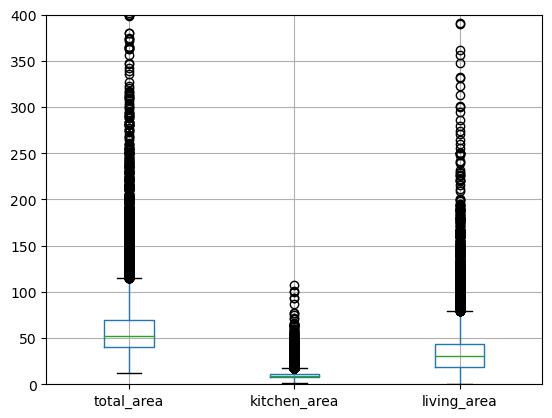

In [14]:
data.boxplot(column = ['total_area','kitchen_area','living_area'])
plt.ylim(0,400)

data[data['total_area']>100].count() #484 строки
data[data['total_area']>320].count() #41 строка
#значений выше 100 очень много, чтобы убирать их все, поэтому повысим планку 


data[data['kitchen_area']>25].count() #150 строк
data[data['kitchen_area']>70].count() #10 строк
#в "кухонных" значениях уберем те, что выше 30
data[data['kitchen_area']<4]['studio'] #проверим, находятся ли кухни с маленькой площадью в студиях
#уберем площади кухни менее 4 кв.м

data['living_area'].describe()
#кажется, значения 0 не должно быть в жилой площади
#Яндекс говорит, что норма минимальной жилой площади(спальни) - 8 кв.м
data = data.query('living_area > 8')
data['living_area'].describe()
#смотрим на "усы"
data[data['living_area']>80].count() #152 строки
data[data['living_area']>250].count() #25 строк

data = data.query('total_area < 320')
data = data.query('kitchen_area < 70 and kitchen_area >4')
data = data.query('living_area < 250')

data.info()

In [15]:
data['rooms'].unique()
#кажется, что не может быть 0 комнат в квартире. Проверим, относятся ли эти данные к студиям
data[data['rooms']==0]['studio'].value_counts()
#135 студии из 190 действительно имеют 0 комнат, уберем только оставшиеся 55.

studio_no_rooms = data.query('studio==True & rooms==0')
studio_no_rooms
data_new = data.query('rooms !=0') #убираем все нулевые комнаты из датафрейма
data_new = data_new.append(studio_no_rooms) #добавляем нужные 135, где нулевые комнаты - это студии
data = data_new #вернемся к изначальному датафрейму, чтобы не путаться
data[data['rooms']==0]['studio'].value_counts() #проверяем

data['rooms'].value_counts()
#уберем также квартиры, где больше 10 комнат, так как это кажется неправдоподобным, и их очень мало
data = data.query('rooms < 10')


C:\Users\Людмила\AppData\Local\Temp\ipykernel_2208\4254359306.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_new.append(studio_no_rooms) #добавляем нужные 135, где нулевые комнаты - это студии


In [16]:
data['floors_total'].value_counts().sort_values()
#самое высокое здание в Санкт-Петербурге - 87 этажей,
#самое высокое жилое здание в Санкт-Петербурге - 37 этажей
data = data.query('floors_total < 37')
data['floor'].value_counts().sort_values() #тут все оставим, как есть, в данных, скорее всего, нет ошибок

data['balcony'].value_counts() #тут тоже оставим все строки

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23170 entries, 0 to 23637
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23170 non-null  int64         
 1   last_price            23170 non-null  int32         
 2   total_area            23170 non-null  float64       
 3   first_day_exposition  23170 non-null  datetime64[ns]
 4   rooms                 23170 non-null  int64         
 5   ceiling_height        23170 non-null  float64       
 6   floors_total          23170 non-null  int32         
 7   living_area           23170 non-null  float64       
 8   floor                 23170 non-null  int64         
 9   is_apartment          23170 non-null  bool          
 10  studio                23170 non-null  bool          
 11  open_plan             23170 non-null  bool          
 12  kitchen_area          23170 non-null  float64       
 13  balcony         

array([2, 0, 3, 1])

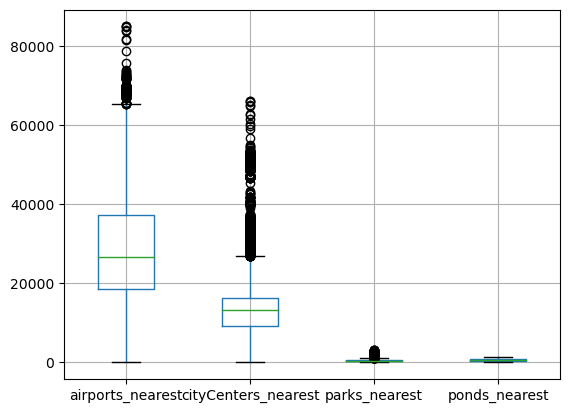

In [17]:
data.boxplot(column = ['airports_nearest','cityCenters_nearest','parks_nearest','ponds_nearest'])

data['airports_nearest'].describe()
#уберем строки, где аэропорт находится в 0 метров от квартиры - кажется неправдоподобным 
data[data['airports_nearest']==0].count() #такая строчка всего одна

data = data[data['airports_nearest']!=0]

#остальные данные оставим,так как они картографические, и расстояние до определенных объектов может быть любым
data['parks_around3000'].unique() #нереалистичных значений нет
data['ponds_around3000'].unique() #нереалистичных значений нет

1580.0

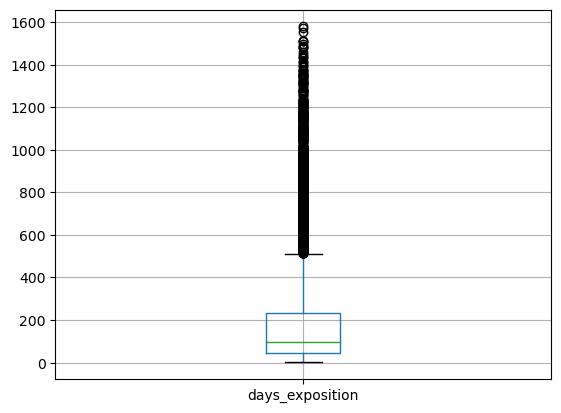

In [18]:
data.boxplot('days_exposition') 
#видно, что значений больше 500 достаточно много - они сливаются в линию, проверим, сколько именно
data[data['days_exposition']>500].count() #1724 значения, то есть это не ошибка системы
data['days_exposition'].max() #1580 - примерно 4 года
#не буду убирать их - интересно посмотреть на параметры таких объявлений
#это могут быть плохие и неисправимые условия, высокая цена, фейки или мошенничество


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23169 entries, 0 to 23637
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23169 non-null  int64         
 1   last_price            23169 non-null  int32         
 2   total_area            23169 non-null  float64       
 3   first_day_exposition  23169 non-null  datetime64[ns]
 4   rooms                 23169 non-null  int64         
 5   ceiling_height        23169 non-null  float64       
 6   floors_total          23169 non-null  int32         
 7   living_area           23169 non-null  float64       
 8   floor                 23169 non-null  int64         
 9   is_apartment          23169 non-null  bool          
 10  studio                23169 non-null  bool          
 11  open_plan             23169 non-null  bool          
 12  kitchen_area          23169 non-null  float64       
 13  balcony         

Итого мы убрали **530 строк - это 2,2%**, так как убирала данные очень осторожно. 
На многих графиках значений за пределами нормы было достаточно много, поэтому их необходимо также брать в расчет (на всякий случай проверяла некоторые данные на сайте Яндекс.Недвижимости - и объявления с такими цифрами действительно существовали, поэтому отбрасывать их было бы неправильно)

In [20]:
data = data.reset_index() #обновляем индексы,чтобы не путаться

### Исследовательский анализ


In [21]:
#считаем цену одного квадратного метра
def price_metre (price, metre):
    one_metre_price = price/metre
    return one_metre_price

data['price_one_metre'] = price_metre(data['last_price'],data['total_area'])

#посмотрим, в какие дни недели были добавлены объявления
data['weekday'] = data['first_day_exposition'].dt.weekday

#проставим месяца публикации объявлений
data['month'] = data['first_day_exposition'].dt.month

#добавим столбец с годом публикации объявления
data['year'] = data['first_day_exposition'].dt.year

#узнаем расстояние до центра города в километрах
data['center_km'] = (data['cityCenters_nearest']/1000).round()

#уточним в отдельном с толбце тип этажа
def floor_type (row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return'последний'
    else:
        return 'другой'

data['floor_type'] = data[['floor', 'floors_total']].apply(floor_type, axis=1)

data.head(20)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_metre,weekday,month,year,center_km,floor_type
0,0,20,13000000,108.00,2019-03-07,3,2.7,16,51.00,8,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,16.0,другой
1,1,7,3350000,40.40,2018-12-04,1,2.5,11,18.60,1,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,19.0,первый
2,2,10,5196000,56.00,2015-08-20,2,2.5,5,34.30,4,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,14.0,другой
3,3,0,64900000,159.00,2015-07-24,3,2.5,14,150.00,9,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,7.0,другой
4,4,2,10000000,100.00,2018-06-19,2,3.0,14,32.00,13,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,8.0,другой
5,5,10,2890000,30.40,2018-09-10,1,2.5,12,14.40,5,...,NaN,0,NaN,55.0,95065.789474,0,9,2018,NaN,другой
6,6,6,3700000,37.30,2017-11-02,1,2.5,26,10.60,6,...,NaN,0,NaN,155.0,99195.710456,3,11,2017,19.0,другой
7,8,20,2900000,33.16,2018-05-23,1,2.5,27,15.43,26,...,NaN,0,NaN,189.0,87454.764777,2,5,2018,NaN,другой
8,9,18,5400000,61.00,2017-02-26,3,2.5,9,43.60,7,...,NaN,0,NaN,289.0,88524.590164,6,2,2017,15.0,другой
9,10,5,5050000,39.60,2017-11-16,1,2.7,12,20.30,3,...,310.0,2,553.0,137.0,127525.252525,3,11,2017,14.0,другой


#### **Посмотрим на параметры объектов**


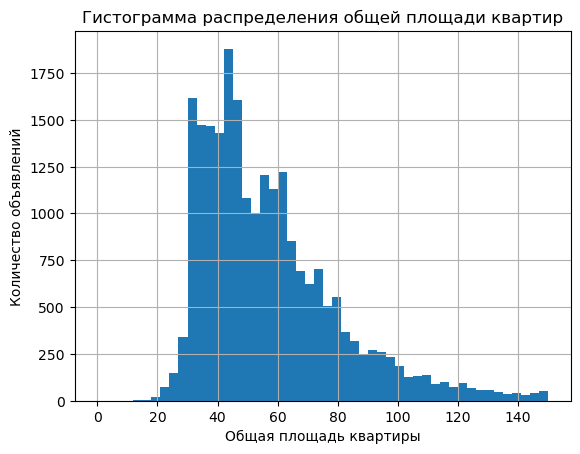

In [22]:
data['total_area'].hist(range = (0,150), bins = 50)
data['total_area'].describe()
plt.title('Гистограмма распределения общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество объявлений');

Самая маленькая площадь квартиры - **12 кв.м.**, самая большая из тех, что мы оставили - **317 кв.м.**


Больше всего квартир с площадями **30-50 метров** (на графике виден резкий рост количества, затем постепенный спад).
<br>
Квартир больше 100 метров становится практически также мало, как и квартир до 30 кв.м.


Среднее и медиана близки - **59 и 52 кв.м.**, значит, сейчас не осталось слишком выбивающихся значений. 

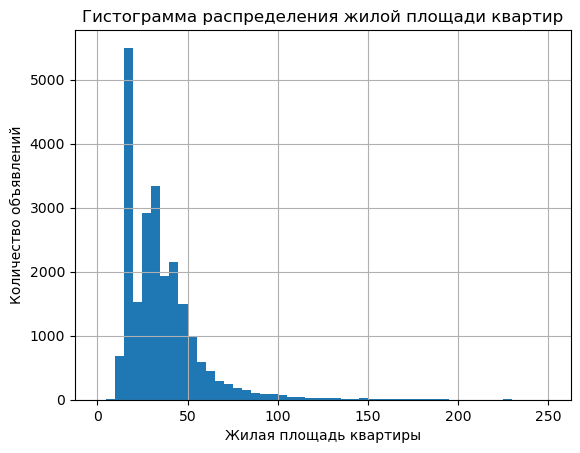

In [23]:
data['living_area'].hist(range = (0,250),bins = 50)
data['living_area'].describe()
plt.title('Гистограмма распределения жилой площади квартир')
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Количество объявлений');

Оставили значения жилой площади в пределах **250 кв.м.**, хотя спад значений происходит уже после **50 кв.м.**
<br>
Если поставить число корзин побольше, то можно заметить резкий спад в районе **20-25 кв.м.**


Минимальное значение - **8 кв.м.** (как мы и обозначили с учетом жилищных норм)
<br>
Среднее и медиана отличаются не сильно - **35 и 30 кв.м.** 

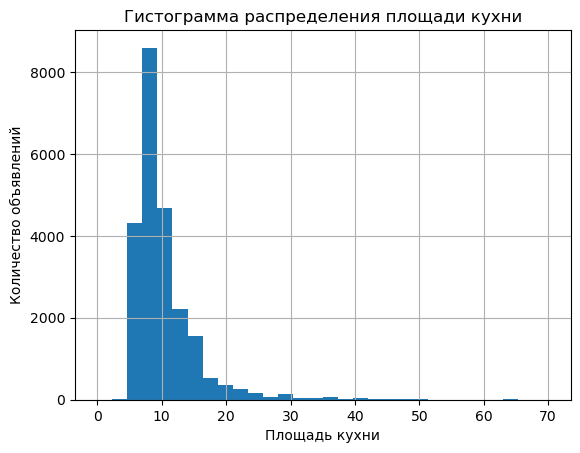

In [24]:
data['kitchen_area'].hist(range = (0,70), bins = 30)
data['kitchen_area'].describe()
plt.title('Гистограмма распределения площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество объявлений');

Минимальная площадь кухни - **4 кв.м.** (как мы и оставляли)
Максимальная - **65 кв.м.**


Среднее и медиана практически равны - **10 и 9 метров**, по графику также видно, что большинство значений именно такие. 
<br>
Спад происходит примерно после **15-18 кв.м.**

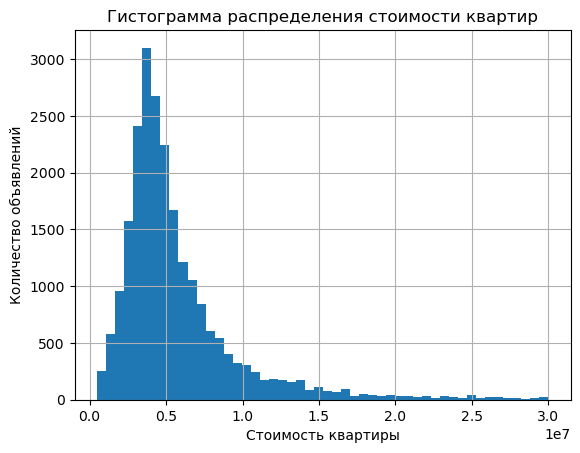

In [25]:
data['last_price'].hist(bins = 50, range = (500000,30000000))
data['last_price'].describe()
plt.title('Гистограмма распределения стоимости квартир')
plt.xlabel('Стоимость квартиры')
plt.ylabel('Количество объявлений');

При предобработке практически не стали убирать даже самые высокие цены, чтобы проверить характеристики таких квартир. На графике же посмотрим, как распределяется цена в нормальном диапазоне - **500.000 - 30.000.000.**


Основные значения - **от 3 до 6 миллионов рублей.**


Минимальная цена - **430 тысяч** (на сайте Недвижимости действительно нашлись такие объявления, поэтому это не ошибка).
<br>
Максимальная - **190 миллионов.**

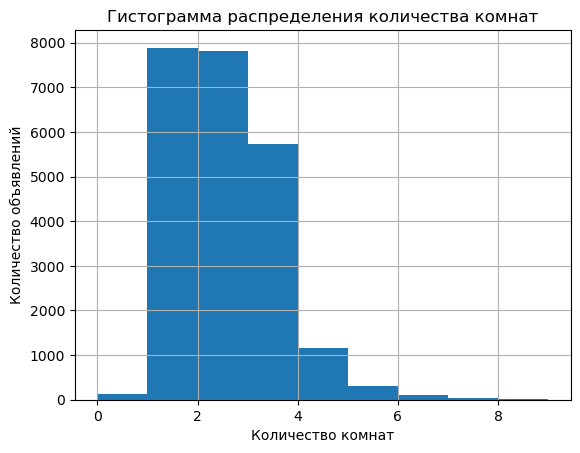

In [26]:
data['rooms'].hist(range = (0,9), bins = 9)
data[data['studio']==True]['rooms'].value_counts() 
plt.title('Гистограмма распределения количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений');

Больше всего квартир **с одной и двумя комнатами**, чуть поменьше - с тремя. 


Квартиры, где 0 комнат - это **студии** (в предобработке оставили только такие), и их практически также мало, как и семикомнатных.
В объявлениях со студиями обычно отмечают либо 0, либо одну комнату. 


Распределение выглядит логичным. 

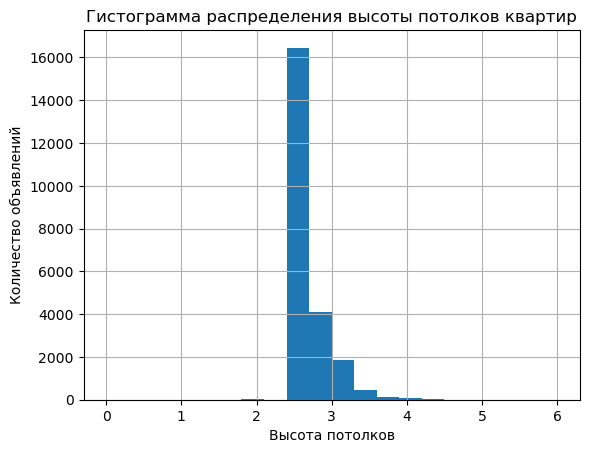

In [27]:
data['ceiling_height'].hist(range = (0,6), bins = 20)
data['ceiling_height'].describe()
plt.title('Гистограмма распределения высоты потолков квартир')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений');

Минимальная высота потолков - **2 метра**, максимальная - **6 метров** (выше 6 метров убрали при предобработке).


Средняя и медианная - **2,6** и **2,5**, выбивающихся значений нет. 
Чаще всего, конечно, встречаются квартиры с потолком 2,5 метра (стандартная высота). 

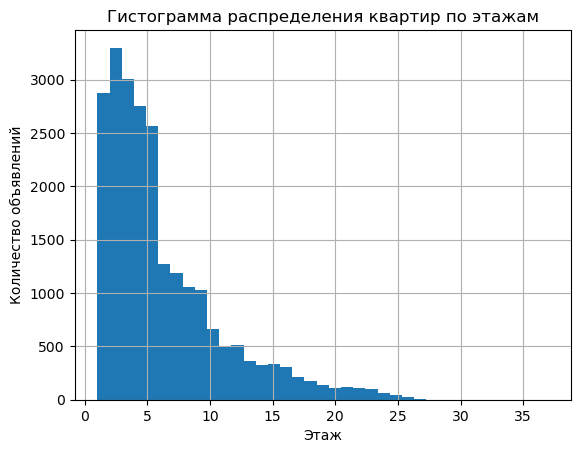

In [28]:
data['floor'].hist(range=(1,37), bins = 37)

plt.title('Гистограмма распределения квартир по этажам')
plt.xlabel('Этаж')
plt.ylabel('Количество объявлений');

В предобработке убрали все дома выше 37 этажей, теперь самый высокий - **33**, самый низкий - **1**. 


Чаще всего встречаются квартиры на **1-6 этажах**, после этого идет резкий спад значений. Это может быть связано с тем, что в Санкт-Петербурге в большинстве своем низкие дома. 

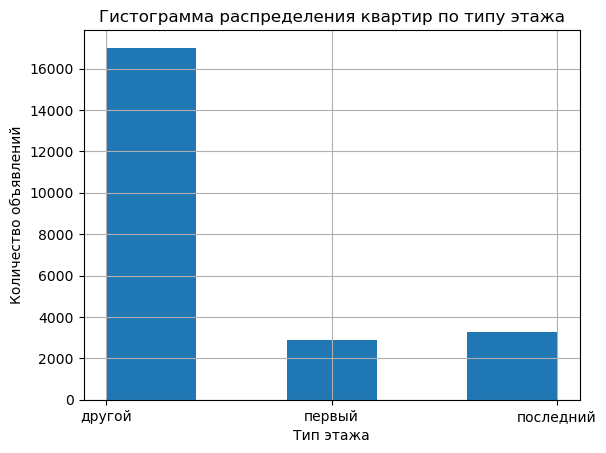

In [29]:
data['floor_type'].hist(bins = 5)
plt.title('Гистограмма распределения квартир по типу этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Количество объявлений');

Больше всего квартир на **"средних"** этажах, первый и последний встечаются практически одинаково редко. Хотя последних все-таки немного больше.  

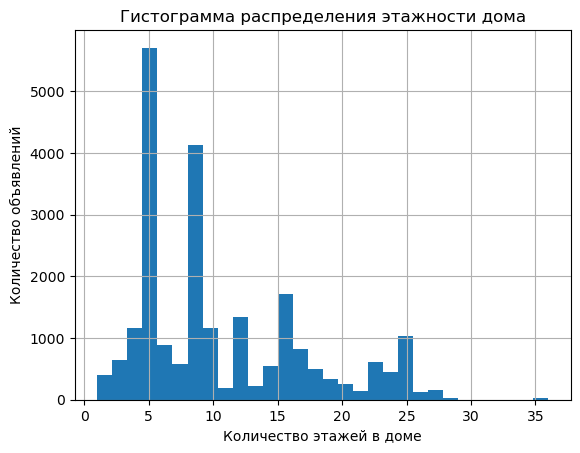

In [30]:
data['floors_total'].hist(bins = 30)
data['floors_total'].describe()
data[data['floors_total']==1]['locality_name'] #одноэтажные дома действительно чаще всего находятся в деревнях и поселках

plt.title('Гистограмма распределения этажности дома')
plt.xlabel('Количество этажей в доме')
plt.ylabel('Количество объявлений');

Самое высокое здание - **36 этажей**, самое низкое - **1 этаж** (возможно, это дома в деревнях, проверим)
<br>
В основном дома **пяти- и девятиэтажные**. Гораздо меньше 16-тиэтажных. 

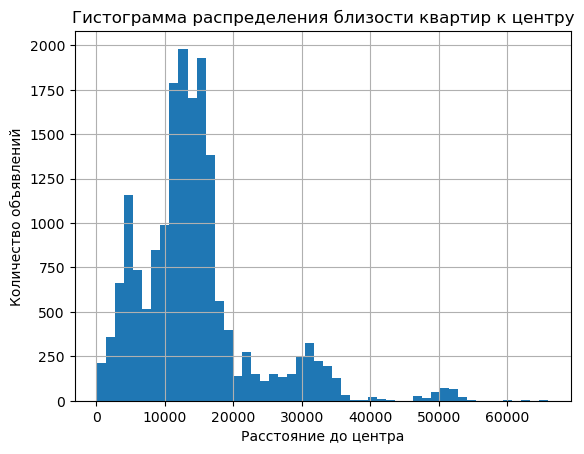

In [31]:
data['cityCenters_nearest'].hist(bins = 50)

plt.title('Гистограмма распределения близости квартир к центру')
plt.xlabel('Расстояние до центра')
plt.ylabel('Количество объявлений');

Самый ближайший к центру дом находится **в 180 метров** в от него. 
<br>
Самый дальний - **в 65,9 километрах** (протяженность области по двум осям составляет 500 и 320 км, значит, такие цифры вполне реальны).

Чаще всего продаются квартиры **в 13-14 км** от центра (медиана и среднее соответственно). 
<br>
Основные значения лежат в диапазоне **до 18 км**, потом начинается резкий спад. 
Также при увеличении корзин можно заметить небольшой спад примерно от 6 до 10 км. 

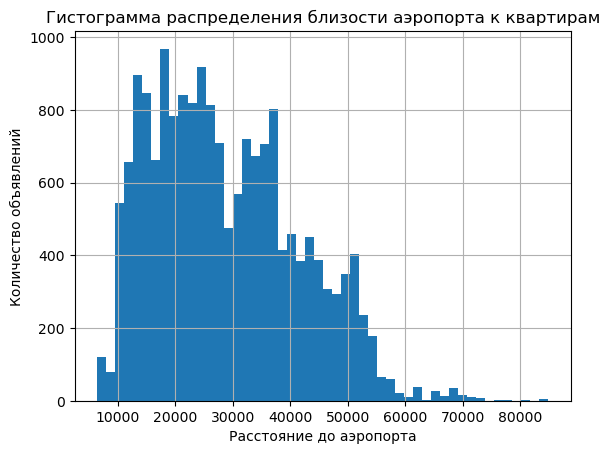

In [32]:
data['airports_nearest'].hist(bins = 50)

plt.title('Гистограмма распределения близости аэропорта к квартирам')
plt.xlabel('Расстояние до аэропорта')
plt.ylabel('Количество объявлений');

Минимальное расстояние до аэропорта - **6,5 км**, максимальное - **84,5 км.**
<br>
Расстояния абсолютно разные, больше всего значений концентрируется в диапазоне **от 10 до 40 км.**

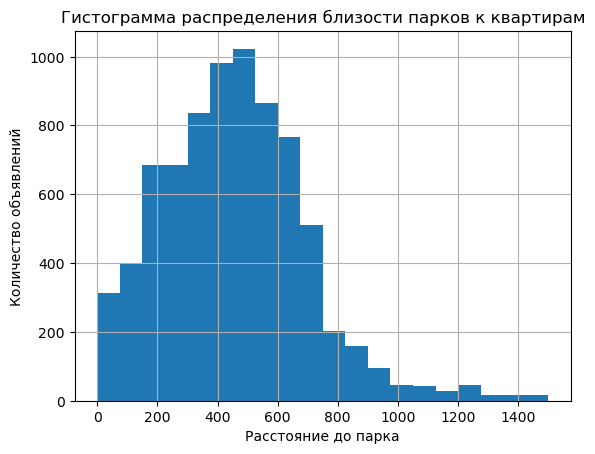

In [33]:
data['parks_nearest'].hist(bins = 20, range = (0, 1500))

plt.title('Гистограмма распределения близости парков к квартирам')
plt.xlabel('Расстояние до парка')
plt.ylabel('Количество объявлений');

Минимальное расстояние до парка - **1 м**, максимальное - **3 км.**
<br>
Значений более 1500 мало, поэтому посмотрим распределение в этих пределах. 
<br>
Чаще всего парки находятся на расстоянии **300 - 700 метров** от дома.  

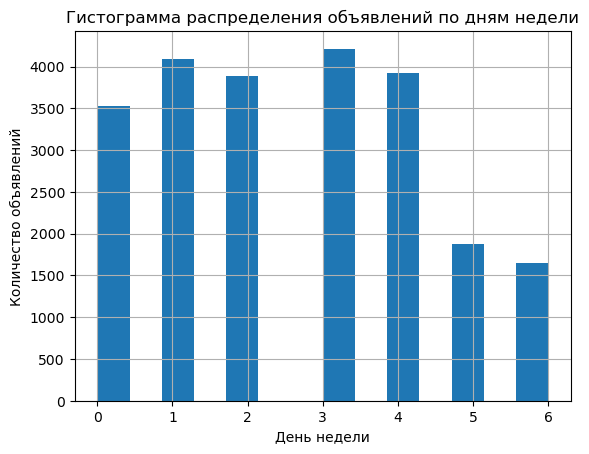

In [34]:
data['weekday'].hist(bins = 14)

plt.title('Гистограмма распределения объявлений по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество объявлений');

**В выходные** объявлений было значительно меньше, чем в другие дни, что в целом логично. 
<br>
Будни практически не отличаются друг от друга частотой, хотя понедельник все же немного отстает. 

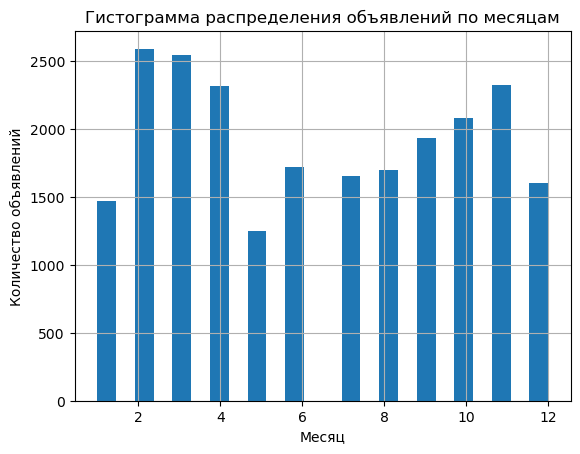

In [35]:
data['month'].hist(bins = 24)

plt.title('Гистограмма распределения объявлений по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество объявлений');

Больше всего объявлений было опубликовано **в феврале, марте, апреле и ноябре**. Меньше всего - **в мае.** 


Спады происходят **летом** (вероятно, потому что многие разъезжаются) и **в декабре** (возможно, это связано с подготовкой к праздникам (финансово и морально) и длинными выходными)
<br>
**В августе** снова начинается постепенный рост, связанный, скорее всего, с поиском квартир студентами. 


#### **Посмотрим, насколько быстро продавались квартиры**

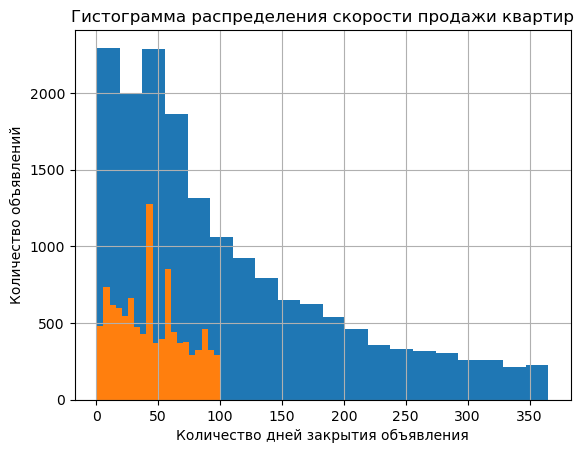

In [36]:
data['days_exposition'].hist(range = (1,365), bins = 20)
data['days_exposition'].hist(range = (1,100), bins = 20)

#попробуем посмотреть на данные без аномальных значений
days_exposition= data[data['days_exposition']<500]
days_exposition['days_exposition'].describe()
days_exposition[days_exposition['days_exposition']<10].count()

plt.title('Гистограмма распределения скорости продажи квартир')
plt.xlabel('Количество дней закрытия объявления')
plt.ylabel('Количество объявлений');

Среднее - 181, медиана - 96. 
Среднее больше медианы в два раза из-за слишком выбивающихся значений, которые мы не стали трогать в предобработке, чтобы оценить причины. 

Если же отбросить значения больше 500 дней (посмотреть на стандартные ситуации), то среднее - 127, медиана - 85. 

Большинство квартир продается в **первые три месяца**, после чего начинается спад. 
Хотя в диапазоне от 1 до 100 есть резкие скачки и спады.

Как мы наблюдали ранее, больше 500 дней - слишком долго, однако такие объявления все равно встречаются, и это не единичные случаи. 

#### **Проанализируем, какие факторы больше всего влияют на стоимость квартир**

Корреляция цены и площади квартиры: 0.72


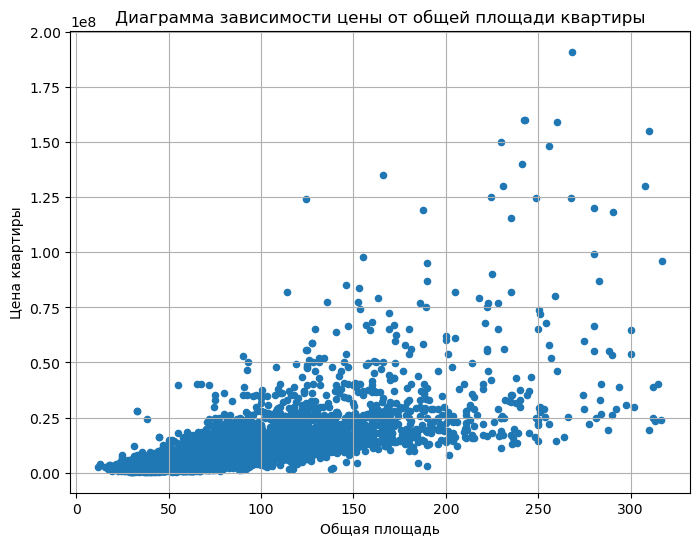

In [37]:
#посмотрим, как зависит цена от общей площади квартиры
total_area_price = data[['total_area','last_price']]
print('Корреляция цены и площади квартиры:',round(data['total_area'].corr(data['last_price']),2)) #корреляция - 0,7

total_area_price.plot(kind = 'scatter', x = 'total_area', y = 'last_price', grid = True, figsize = (8,6))
plt.title('Диаграмма зависимости цены от общей площади квартиры')
plt.xlabel('Общая площадь')
plt.ylabel('Цена квартиры');

Как и ожидалось, цена квартиры **растет при увеличении** площади. Коэффициент корреляции составляет **0,7**, то есть величины имеют сильную положительную связь. 

На площадях примерно **до 80 кв.м** цены еще не сильно колеблются, и даже могут быть одинаковы. 
<br>
Однако **от 150 кв.м**. разница в стоимости становится огромной, и может достигать нескольких десятков, или даже сотню миллионов. Такие квартиры рассчитаны на очень состоятельных людей и, скорее всего, различаются внутренней "начинкой" квартиры: встроенной техникой, ремонтом, престижностью района, инфраструктурой, дальностью от центра. 

Корреляция цены и площади квартиры:
             living_area  last_price
living_area     1.000000    0.630101
last_price      0.630101    1.000000

Корреляция общей площади и жилой площади: 0.92


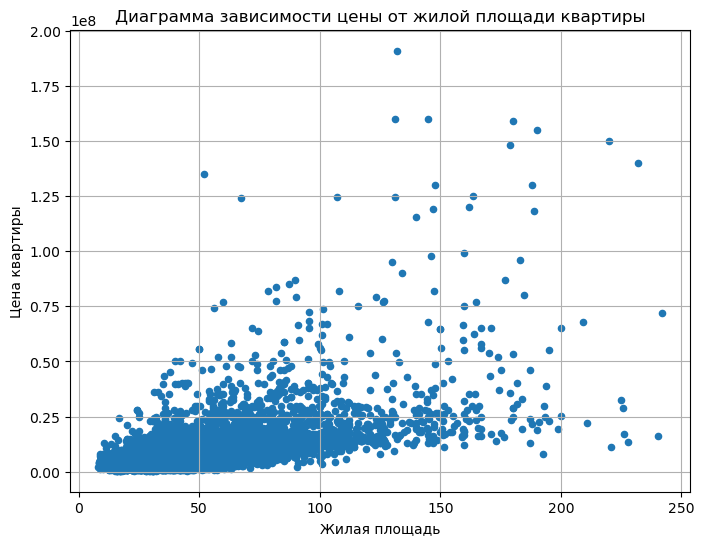

In [38]:
#проанализируем взаимосвязь жилой площади и цены квартиры
living_area_price = data[['living_area','last_price']]
living_area_price.plot(kind = 'scatter', x = 'living_area', y = 'last_price', grid = True, figsize = (8,6))
plt.title('Диаграмма зависимости цены от жилой площади квартиры')
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры');

print('Корреляция цены и площади квартиры:') 
print(living_area_price.corr()) #0,63
print()

#проверим корреляцию общей и жилой площади
print('Корреляция общей площади и жилой площади:', round(data['total_area'].corr(data['living_area']),2)) 
#0,92 - очень сильная зависимость, но не абсолютная

**Корреляция жилой площади и цены** также прямая, однако уже не такая сильная, как у общей площади (0,63).

В целом график похож на график зависимости от общей площади: цены **в первых 50-ти кв.метрах** не сильно отличаются, и могут даже совпадать. Однако здесь различия в стоимости квартир с одинаковыми жилыми площадями начинают появляться раньше: уже от 40 кв.м. **От 100 кв.м.** цены часто ищеют существенную разницу (почти в 10 раз)

Это может объясняться важностью площадей нежилых комнат: ванной, кладовой, балконов. 

Корреляция цены и площади кухни:
              kitchen_area  last_price
kitchen_area      1.000000    0.504033
last_price        0.504033    1.000000

Зависимость жилой площади от площади кухни: 0.34


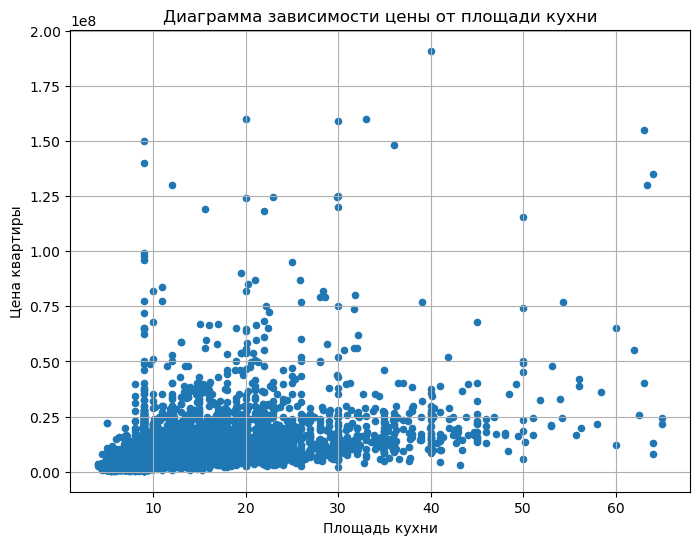

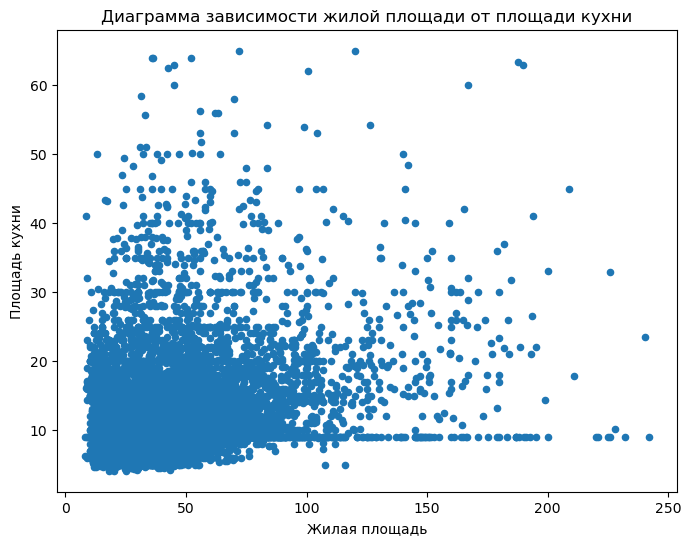

In [39]:
#проверим, как сильно влияет площадь кухни на сттоимость квартиры
kitchen_area_price = data[['kitchen_area','last_price']]
kitchen_area_price.plot(kind = 'scatter', x = 'kitchen_area', y = 'last_price', grid = True, figsize = (8,6))
plt.title('Диаграмма зависимости цены от площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры');

print('Корреляция цены и площади кухни:')
print(kitchen_area_price.corr())
print()

#проверим корреляцию жилой площади и кухни
print('Зависимость жилой площади от площади кухни:', round(data['living_area'].corr(data['kitchen_area']),2))

data.plot(kind = 'scatter', x = 'living_area', y = 'kitchen_area', figsize = (8,6))
plt.title('Диаграмма зависимости жилой площади от площади кухни')
plt.xlabel('Жилая площадь')
plt.ylabel('Площадь кухни');

Зависимость цены от площади кухни действительно есть, хотя и меньше, чем от общей и жилой площадей - **0,5.**
<br>
Значения более-менее стабильны **до 35 кв.м**, далее начинаются разбросы. Несмотря на это, выбросы встречаются уже от 9 кв.м.

Взаимосвязь между жилой площадью и кухней небольшая - **0,3**. 
На графике заметно, что площадь кухни 10 кв.м. может быть в квартире с практически любой жилой площадью. 

Корреляция между стоимостью квартиры и количеством комнат: 0.43


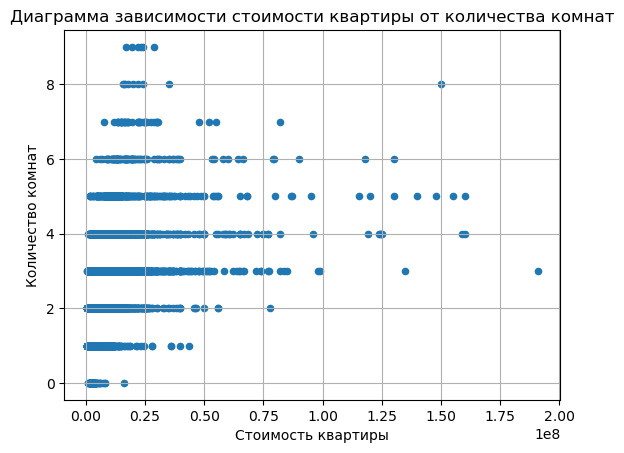

In [40]:
#узнаем взаимосвязь между количеством комнат и ценой
print('Корреляция между стоимостью квартиры и количеством комнат:', round(data['rooms'].corr(data['last_price']),2)) 

data.pivot_table(index='rooms', values = 'last_price', aggfunc = 'median')

data.plot(y = 'rooms', x = 'last_price', kind = 'scatter', grid = True)
plt.title('Диаграмма зависимости стоимости квартиры от количества комнат')
plt.xlabel('Стоимость квартиры')
plt.ylabel('Количество комнат');

Самые дешевые цены **у студий и девятикомнатных квартир**, самые дорогие - квартиры **с тремя, четырьмя и пятью комнатами.** 

Корреляция составляет **0,4**, то есть существует положительная зависимость, но не очень сильная, либо зависит от других факторов: площади квартиры, качества спроса (квартиры с 1-3 комнатами более востребованы, чем с 7-9).

Корреляция стоимости и типа этажа: 0.03


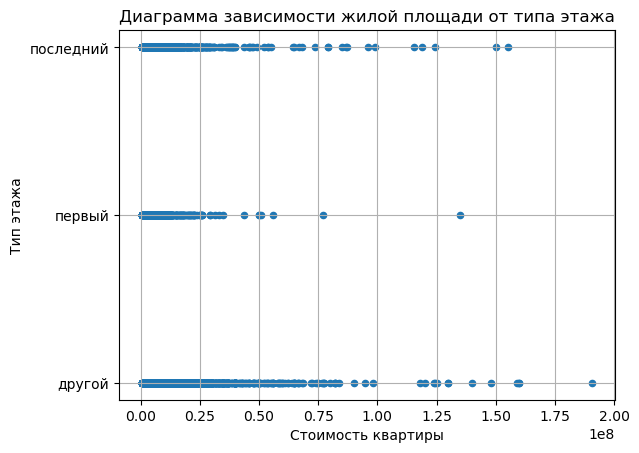

In [41]:
#проверим, как влияет тип этажа на цену
data.plot(y = 'floor_type', x = 'last_price', kind = 'scatter', grid = True)
plt.title('Диаграмма зависимости жилой площади от типа этажа')
plt.xlabel('Стоимость квартиры')
plt.ylabel('Тип этажа');

data.groupby('floor_type')['last_price'].median()

#посмотрим на корреляцию цены и этажа
print('Корреляция стоимости и типа этажа:', round(data['floor'].corr(data['last_price']),2)) 

Квартиры **на первом этаже** дешевле других, что объясняется их непопулярностью. 
<br>
Самые дорогие - **на средних этажах**, тем не менее разница между стоимостью последнего и других этажей очень маленькая. 

Зависимости между этажом и ценой **не обнаружено.**

In [42]:
#посмотрим, зависит ли цена от даты размещения
print('Корреляция месяца размещения и цены:',round(data['month'].corr(data['last_price']),3)) 
print('Корреляция дня недели и цены:',round(data['weekday'].corr(data['last_price']),4)) 
print('Корреляция года размещения и цены:',round(data['year'].corr(data['last_price']),3))


Корреляция месяца размещения и цены: 0.005
Корреляция дня недели и цены: -0.0005
Корреляция года размещения и цены: -0.055


Зависимости между ценой и датой размещения объявления **не обнаружено**, либо имеет более сложный характер. 

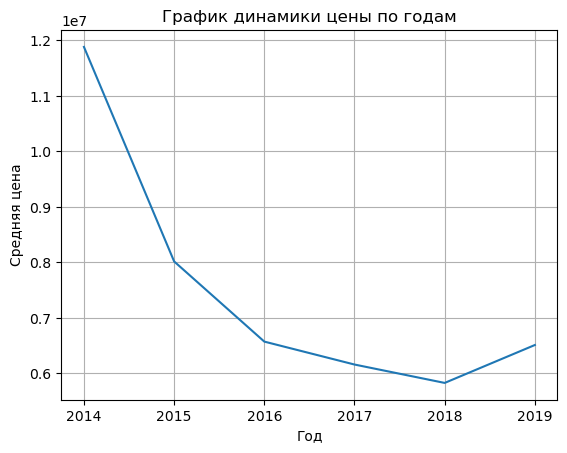

In [43]:
#gjcvjnhbv на динамику по годам
data.groupby('year')['last_price'].mean().plot(grid = True)
plt.title('График динамики цены по годам')
plt.xlabel('Год')
plt.ylabel('Средняя цена');

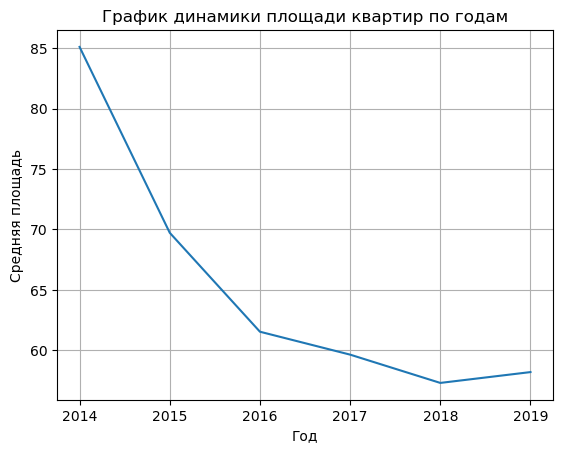

In [44]:
data.groupby('year')['total_area'].mean().plot(grid = True)
plt.title('График динамики площади квартир по годам')
plt.xlabel('Год')
plt.ylabel('Средняя площадь');

И цены, и площади продаваемых квартир падали вплоть до **2018 года**, после чего произошел небольшой подъем. 

#### **Посчитаем цены в разных населенных пунктах**

In [45]:
#найдем 10 наиболее частых населенных пунктов
top_locations = list(data.groupby('locality_name')['price_one_metre'].count().sort_values(ascending = False)[:10].index)

#создадим цикл, который посчитает и округлит среднюю цену для каждого населенного пункта из топ-10 
top_locations_median = []
for location in top_locations:
    median = round(data[data['locality_name']==location]['price_one_metre'].median())
    top_locations_median.append(median)

#объединим списки в датафрейм для наглядности
locations_median_price = pd.DataFrame(top_locations_median, top_locations, columns = ['median_price'])
locations_median_price.sort_values(by='median_price', ascending = False)

,median_price
Санкт-Петербург,104444
Пушкин,99987
посёлок Парголово,91780
деревня Кудрово,91667
посёлок Мурино,85620
посёлок Шушары,76829
Колпино,74722
Гатчина,67672
Всеволожск,65789
Выборг,58407



    
Самые высокие цены на кв.м., конечно, в столице - **Санкт-Петербурге**: медианна стоимость составляет **104 тысячи**. После него идет город **Пушкин** с ценой **99,9 тысяч.** 
<br>
Самые дешевые метры (из наиболее популярных населенных пунктов) в **Выборге (58 тысяч), Всеволожске (65 тысяч) и Гатчине(67 тысяч).**

Интересно, что цены в некоторых поселках и деревнях даже выше, чем в известных городах. Скорее всего, это связано **с расстоянием до Санкт-Петербурга** (если сверить по карте ЛО, то выглядит именно так).


#### **Посмотрим, как стоимость объектов зависит от расстояния до центра Санкт-Петербурга**

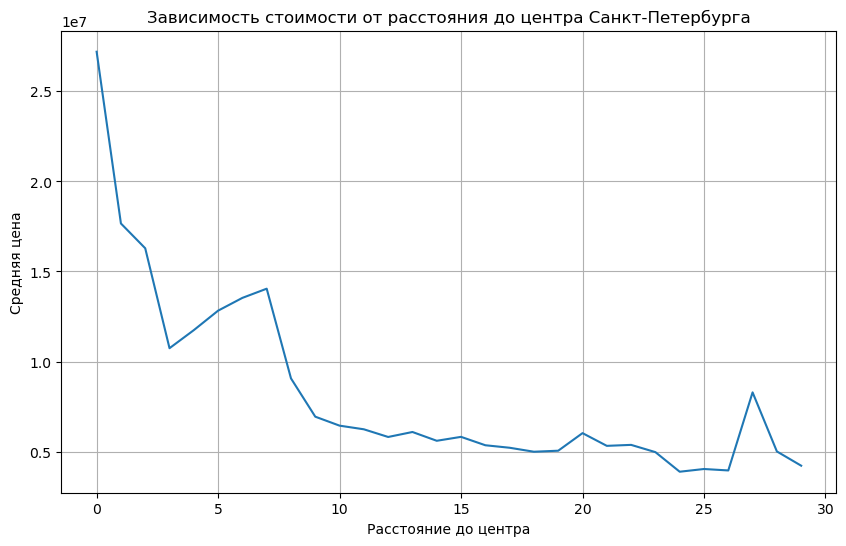

In [46]:
#возьмем данные только по Санкт-Петербургу, сгруппируем по расстоянию до центра и посчитаем среднюю цену
spb_data = data[data['locality_name']=='Санкт-Петербург']
price_km = spb_data.groupby('center_km')['last_price'].mean().round()
price_km.plot(grid = True, figsize = (10,6))
plt.title('Зависимость стоимости от расстояния до центра Санкт-Петербурга')
plt.xlabel('Расстояние до центра')
plt.ylabel('Средняя цена');

Стоимость квартир, которые находятся прямо в центре города, достигает **27 млн рублей**, а вот объекты в 1-2 км уже **на 10 миллионов дешевле.** 

Тенденция такая: чем **дальше от центра**, тем **ниже цена** квартиры. Однако на графике можно наблюдать два пика в районе **7 и 27 км**, которые могут быть связаны с другими условиями: например, хорошей инфраструктурой (первый пик) и наличием парков и прудов (второй пик)

Также **после восьмого километра** цены отличаются уже не так сильно: разница составляет около миллиона или даже меньше. 

Самые дешевые квартиры оказались **в 24 км от центра.** 

### Общий вывод

Данные, собранные с сайта Яндекс.Недвижимости имели некоторые отклонения от нормальных значений. 
Многие из них (те, которые выглядели реалистичными) мы все же оставили, чтобы посмотреть их влияние на общую стоимость.


Был проведен исследовательский анализ данных, рассмотрены различные факторы и их влияние на стоимость объектов, а также влияние некоторых из них друг на друга. 

Итого мы выяснили, что **большинство квартир** в Санкт-Петербурге и Ленинградской области имеют следующие параметры:
- общая площадь: 30-50 кв.м
- жилая площадь: 30-35 кв.м
- площадь кухни: 9-10 кв.м
- цена: 3-6 млн.рублей
- имеют 1 или 2 комнаты
- высота потолков: 2,5 м
- этаж: 4, 5
- этажей в доме: 5 или 9
- расстояние до центра: 13-14 км
- расстояние до аэропорта: 26-28 км
- расстояние до парков: 300-700 метров
- чаще публикуются в будни
- чаще публикуются в феврале, марте, апреле и ноябре

Большинство квартир продается **в первые три месяца** после публикации. 

**Стоимость квартиры** напрямую зависит от следующих факторов: 
- общая площадь, сильная положительная корреляция (0,7)
- жилая площадь, сильная положительная корреляция (0,63)
- площадь кухни, средняя положительная корреляция (0,5)
- количество комнат, средняя положительная корреляция (0,4)
- тип этажа: квартиры на первом этаже гораздо дешевле

Зависимости между ценой и датой публикации не обнаружено